## Visualize the decision of the classifier
In this notebook we will learn how to use Class Acvitation Maps (CAM) (https://arxiv.org/abs/1512.04150). <br />
A method to visualize image regions most important for the decision of the classifier.

## Imports

* torch for tensor manipulation
* torchvision for resnet18
* transforms for Normalization
* pytorch lightning for model creation
* numpy for data loading
* matplotlib for plotting

# Pneumonia Detection – Model Interpretability

This notebook focuses on understanding how our trained deep learning model makes predictions when analyzing chest X-ray images. Instead of evaluating model performance, here we aim to visualize which regions of an image are most influential in the decision process using Class Activation Maps (CAM).

We use a trained ResNet18 model adapted for grayscale medical images and binary classification. The idea is to extract the final feature maps from the convolutional layers, combine them with the learned weights of the final fully connected layer, and generate a heatmap that highlights areas contributing most to the classification (pneumonia vs healthy).

This approach helps improve the transparency and trust in AI-based medical diagnostics.

In [1]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

### Load validation dataset (preprocessed)

We start by loading the validation images that were preprocessed and saved in `.npy` format. These images were originally DICOM chest X-rays resized to 224x224 and saved as NumPy arrays.

Since the data is already preprocessed, we use a custom loader that reads `.npy` files and converts them to `float32`. We then apply standard PyTorch transformations: converting to tensors and normalizing based on the mean and standard deviation calculated from the training set.


In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)


In [3]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248),

])

val_dataset = torchvision.datasets.DatasetFolder("../data/Processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

### How Class Activation Maps (CAM) Work

The core idea behind Class Activation Maps (CAM) is to identify **which parts of an image contributed most to a model's prediction**.

To do this, we focus on the output of the **last convolutional layer** of our ResNet18 model. Each channel in this layer corresponds to a learned pattern or feature map, denoted as $A_k$ for channel $k$.

The final classification decision is based on a **linear combination** of these features, using the learned weights $w_k$ from the fully connected layer:

$$ M = \sum_k w_k A_k $$

Where:
- $A_k$ is the activation map (feature map) for channel $k$
- $w_k$ is the weight associated with that channel from the final layer

The result $M$ is a 2D map (typically 7x7), which highlights the areas in the image that were most influential in the decision.

To implement this, we first load a ResNet18 model and inspect its architecture to locate the final convolutional layer we want to extract.


In [4]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Extracting the Feature Extraction Layers

In PyTorch, we can use the `.children()` method to iterate over the main building blocks of a model. This is useful when we want to isolate certain parts of the architecture.

In our case, we are interested only in the **convolutional part** of ResNet18, which includes all layers **up to (but not including)** the `AdaptiveAvgPool2d` layer. This part of the network is responsible for extracting spatial features from the input image.

By converting the `.children()` generator into a list, we can easily slice it and remove the last two layers: the average pooling and the final fully connected layer.


In [5]:
list(temp_model.children())[:-2]  # get all layers up to avgpool

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

Using **Sequential** from pytorch, we convert the list of layers back to a Sequential Model.


In [6]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

We now define a custom PyTorch Lightning module that adapts the ResNet18 architecture for grayscale medical images and allows us to extract feature maps from the last convolutional layer.

Key modifications:
- The first convolutional layer is changed to accept 1-channel images instead of 3 (grayscale input).
- The final fully connected layer is changed to output a single value (binary classification: pneumonia vs healthy).
- We explicitly extract all convolutional layers up to the final pooling layer using `.children()[:-2]`.

In the `forward()` function, we return:
- The final class prediction
- The raw feature maps (512x7x7), which will be used for CAM visualization


In [7]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    
    def forward(self, data):
        
        # Compute feature map
        feature_map = self.feature_map(data)
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map
    


In this step, we re-create the architecture of the model we trained earlier for pneumonia detection.


In [8]:
# Use strict to prevent pytorch from loading weights for self.feature_map
model = PneumoniaModel.load_from_checkpoint("../weights/ckpts_balanced/balanced-epoch=17-val_acc=0.81.ckpt", strict=False)
model.eval();

C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\core\saving.py:205: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_ma

## Computing Class Activation Maps (CAM)

To understand which regions of the input image contributed most to the model's prediction, we compute a Class Activation Map (CAM).

### Recap: What are features and weights?

- After the image passes through the convolutional layers, the model produces 512 **feature maps**. Each one highlights where a specific learned pattern (e.g., texture, edge, opacity) is present in the image.
- The **fully connected layer** uses 512 **weights**, one for each feature map, to combine these patterns into a single prediction.

### The CAM formula:

We compute a weighted sum over the 512 feature maps, using the weights from the fully connected layer:

$$ M = \sum_k w_k A_k $$

Where:
- \( A_k \): activation map (feature map) for channel \( k \)
- \( w_k \): weight learned for that feature in the final decision

This results in a single 7x7 heatmap that reflects the regions most influential in the classification (i.e., where the "evidence" for pneumonia is strongest).

We then resize this map and overlay it onto the original image to visually interpret the model's reasoning.


In [17]:
def cam(model, img):
    """
    Compute class activation map according to cam algorithm
    """
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape

    # We reshape the 512x7x7 feature tensor into a 512x49 tensor in order to simplify the multiplication
    features = features.reshape((c, h*w))
    
    # Get only the weights, not the bias
    weight_params = list(model.model.fc.parameters())[0] 
    
    # Remove gradient information from weight parameters to enable numpy conversion
    weight = weight_params[0].detach()
    print(weight.shape)
    # Compute multiplication between weight and features with the formula from above.
    # We use matmul because it directly multiplies each filter with the weights
    # and then computes the sum. This yields a vector of 49 (7x7 elements)
    cam = torch.matmul(weight, features)
    print(features.shape)
    
    ### The following loop performs the same operations in a less optimized way
    #cam = torch.zeros((7 * 7))
    #for i in range(len(cam)):
    #    cam[i] = torch.sum(weight*features[:,i])
    ##################################################################
    
    # Normalize and standardize the class activation map (Not always necessary, thus not shown in the lecture)
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    # Reshape the class activation map to 512x7x7 and move the tensor back to CPU
    cam_img = cam_img.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)

def visualize(img, heatmap, pred):
    """
    Visualization function for class activation maps
    """
    img = img[0]
    # Resize the activation map of size 7x7 to the original image size (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]
    
    # Create a figure
    fig, axis = plt.subplots(1, 2)
    
    axis[0].imshow(img, cmap="bone")
    # Overlay the original image with the upscaled class activation map
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    plt.title(f"Pneumonia: {(pred > 0.5).item()}")

## Demo Time

In [20]:
img = val_dataset[500][0]  # Select a subject
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 49])


<IPython.core.display.Javascript object>


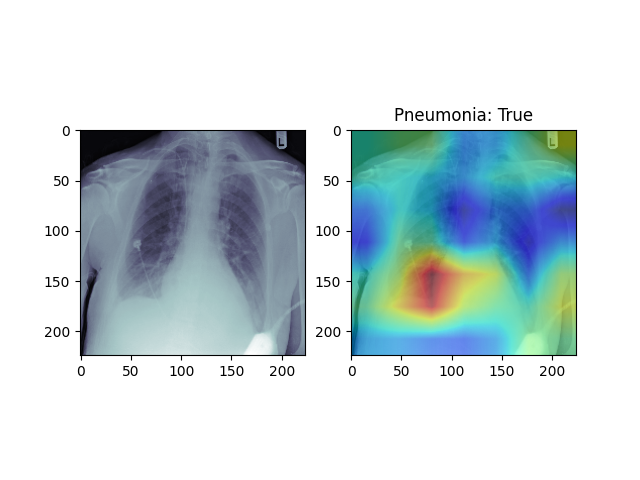

In [21]:
visualize(img, activation_map, pred)  # Visualize CAM

The heatmap focuses on the area which shows signs of pneumonia, isn't that cool?

Awesome, you made it! <br />
You can try out this method for all neural networks with one restriction: The classic CAM algorithm requrires a specific network architecture:<br />
Last Convolution $\rightarrow$ Global Average Pool $\rightarrow$ 1 FC Layer.

For other network architectures, you either need to adapt the architecture, followed by retraining our use different methods such as GradCAM or ScoreCAM (https://arxiv.org/abs/1610.02391), (https://arxiv.org/abs/1910.01279)